# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Lab 2 - Smoothers and Generalized Additive Models - Model Fitting

<div class="discussion"><b>Spring 2020</b></div>

**Harvard University**<br>
**Spring 2020**<br>
**Instructors:** Mark Glickman, Pavlos Protopapas, and Chris Tanner<br>
**Lab Instructors:** Chris Tanner and Eleni Kaxiras<br>
**Content:** Eleni Kaxiras and Will Claybaugh

---

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

ConnectionError: HTTPSConnectionPool(host='raw.githubusercontent.com', port=443): Max retries exceeded with url: /Harvard-IACS/2019-CS109B/master/content/styles/cs109.css (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x1035e6990>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [2]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline 

## Learning Goals

By the end of this lab, you should be able to:
* Understand how to implement GAMs with the Python package `pyGAM`
* Learn about the practical aspects of Splines and how to use them.

**This lab corresponds to lectures 1, 2, and 3 and maps to homework 1.**

## Table of Contents

* 1 - Overview - A Top View of LMs, GLMs, and GAMs to set the stage
* 2 - A review of Linear Regression with `statsmodels`. What are those weird formulas?
* 3 - Splines
* 4 - Generative Additive Models with pyGAM
* 5 - Smooting Splines using pyGAM

## Overview

Linear Models (LM), Generalized Linear Models (GLMs), Generalized Additive Models (GAMs), Splines, Natural Splines, Smoothing Splines! So many definitions. Let's try and work through an example for each of them so we can better understand them. 

![](../images/GAM_venn.png)
*image source: Dani Servén Marín (one of the developers of pyGAM)*

### A - Linear Models

First we have the **Linear Models** which you know from 109a. These models are linear in the coefficients. Very *interpretable* but suffer from high bias because let's face it, few relationships in life are linear. Simple Linear Regression (defined as a model with one predictor) as well as Multiple Linear Regression (more than one predictors) are examples of LMs. Polynomial Regression extends the linear model by adding terms that are still linear for the coefficients but non-linear when it somes to the predictiors which are now raised in a power or multiplied between them.

![](../images/linear.png)

$$
\begin{aligned}
y = \beta{_0} + \beta{_1}{x_1} &  \mbox{(simple linear regression)}\\
y = \beta{_0} + \beta{_1}{x_1} + \beta{_2}{x_2} + \beta{_3}{x_3} &  \mbox{(multiple linear regression)}\\
y = \beta{_0} + \beta{_1}{x_1} + \beta{_2}{x_1^2} + \beta{_3}{x_3^3} &  \mbox{(polynomial regression)}\\
\end{aligned}
$$

<div class="discussion"><b>Discussion</b></div>

 - What does it mean for a model to be **interpretable**?
 - Are linear regression models interpretable? Are random forests? What about Neural Networks such as FFNs and CNNs? 
 - Do we always want interpretability? Describe cases where we do and cases where we do not care. 


### B - Generalized Linear Models (GLMs)

![](../images/GLM.png)

$$
\begin{aligned}
y = \beta{_0} + \beta{_1}{x_1} + \beta{_2}{x_2} + \beta{_3}{x_3}
\end{aligned}
$$


**Generalized Linear Models** is a term coined in the early 1970s by Nelder and Wedderburn for a class of models that includes both Linear Regression and Logistic Regression. A GLM fits one coefficient per feature (predictor). 

### C - Generalized Additive Models (GAMs)

Hastie and Tidshirani coined the term **Generalized Additive Models** in 1986 for a class of non-linear extensions to Generalized Linear Models.

![](../images/GAM.png)

$$
\begin{aligned}
y = \beta{_0} + f_1\left(x_1\right) + f_2\left(x_2\right) + f_3\left(x_3\right) \\
y = \beta{_0} + f_1\left(x_1\right) + f_2\left(x_2, x_3\right) + f_3\left(x_3\right) &  \mbox{(with interaction terms)}
\end{aligned}
$$

In practice we add splines and regularization via smoothing penalties to our GLMs. Decision Trees also fit in this category.

*image source: Dani Servén Marín*

### D - Basis Functions

In our models we can use various types of functions as "basis". 
- Monomials such as $x^2$, $x^4$ (**Polynomial Regression**)
- Sigmoid functions (neural networks)
- Fourier functions 
- Wavelets 
- **Regression splines** which we will look at shortly.

<div class="discussion"><b>Discussion</b></div>

 - Where does polynomial regression fit in all this?

Answer: GLMs include Polynomial Regression so the graphic above should really include curved lines, not just straight...

## Implementation

### 1 - Linear/Polynomial Regression

We will use the `diabetes` dataset.

Variables are:
- subject:   subject ID number
- age:       age diagnosed with diabetes
- acidity:   a measure of acidity called base deficit
Response:
- y:         natural log of serum C-peptide concentration

*Original source is Sockett et al. (1987) mentioned in Hastie and Tibshirani's book 
"Generalized Additive Models".*




Reading data and (some) exploring in Pandas:

In [3]:
diab = pd.read_csv("../data/diabetes.csv")
diab.head()

,subject,age,acidity,y
0,1,5.2,-8.1,4.8
1,2,8.8,-16.1,4.1
2,3,10.5,-0.9,5.2
3,4,10.6,-7.8,5.5
4,5,10.4,-29.0,5.0


In [4]:
diab.dtypes

subject      int64
age        float64
acidity    float64
y          float64
dtype: object

In [5]:
diab.describe()

,subject,age,acidity,y
count,43.000000,43.000000,43.000000,43.000000
mean,22.000000,9.032558,-8.148837,4.746512
std,12.556539,4.022539,7.123080,0.720565
min,1.000000,0.900000,-29.000000,3.000000
25%,11.500000,5.500000,-12.700000,4.450000
50%,22.000000,10.400000,-7.800000,4.900000
75%,32.500000,11.850000,-2.000000,5.100000
max,43.000000,15.600000,-0.200000,6.600000


Plotting with matplotlib:

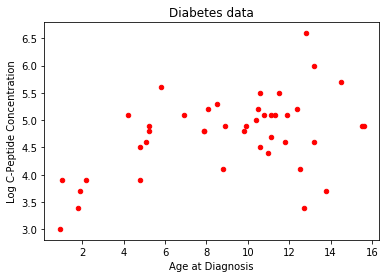

In [6]:
ax0 = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data") #plotting direclty from pandas!
ax0.set_xlabel("Age at Diagnosis")
ax0.set_ylabel("Log C-Peptide Concentration");

### Linear/Polynomial regression with statsmodels. 

As you remember from 109a, we have two tools for Linear Regression:
- `statsmodels` [https://www.statsmodels.org/stable/regression.html](https://www.statsmodels.org/stable/regression.html), and 
- `sklearn`[https://scikit-learn.org/stable/index.html](https://scikit-learn.org/stable/index.html)

Previously, we worked from a vector of target values and a design matrix we built ourself (e.g. using `sklearn`'s PolynomialFeatures). `statsmodels` allows users to fit statistical models using R-style **formulas**. They build the target value and design matrix for you. 

```
# our target variable is 'Lottery', while 'Region' is a categorical predictor
df = dta.data[['Lottery', 'Literacy', 'Wealth', 'Region']]

formula='Lottery ~ Literacy + Wealth + C(Region) + Literacy * Wealth'
```

For more on these formulas see:

- https://www.statsmodels.org/stable/examples/notebooks/generated/formulas.html
- https://patsy.readthedocs.io/en/latest/overview.html 

In [6]:
import statsmodels.formula.api as sm

model1 = sm.ols('y ~ age',data=diab)
fit1_lm = model1.fit()

Let's build a dataframe to predict values on (sometimes this is just the test or validation set). Very useful for making pretty plots of the model predictions - predict for TONS of values, not just whatever's in the training set.

In [7]:
x_pred = np.linspace(0,16,100)

predict_df = pd.DataFrame(data={"age":x_pred})
predict_df.head()

,age
0,0.000000
1,0.161616
2,0.323232
3,0.484848
4,0.646465


Use `get_prediction(<data>).summary_frame()` to get the model's prediction (and error bars!)

In [9]:
prediction_output = fit1_lm.get_prediction(predict_df).summary_frame()
prediction_output.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3.996031,0.244590,3.502071,4.489991,2.600828,5.391235
1,4.009459,0.240929,3.522892,4.496026,2.616856,5.402063
2,4.022887,0.237280,3.543691,4.502084,2.632842,5.412932
3,4.036315,0.233642,3.564466,4.508165,2.648786,5.423845
4,4.049743,0.230016,3.585216,4.514270,2.664687,5.434800


Plot the model and error bars

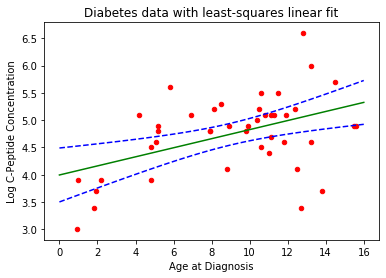

In [10]:
ax1 = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data with least-squares linear fit")
ax1.set_xlabel("Age at Diagnosis")
ax1.set_ylabel("Log C-Peptide Concentration")

ax1.plot(predict_df.age, prediction_output['mean'],color="green")
ax1.plot(predict_df.age, prediction_output['mean_ci_lower'], color="blue",linestyle="dashed")
ax1.plot(predict_df.age, prediction_output['mean_ci_upper'], color="blue",linestyle="dashed");

<div class="exercise"><b>Exercise 1</b></div>

- Fit a 3rd degree polynomial model and
- plot the model+error bars.

You can either take 
- **Route1**: Build a design df with a column for each of `age`, `age**2`, `age**3`, or 
- **Route2**: Just edit the formula

In [ ]:
# your answer here


In [11]:
# %load ../solutions/exercise1-1.py
fit2_lm = sm.ols(formula="y ~ age + np.power(age, 2) + np.power(age, 3)",data=diab).fit()

poly_predictions = fit2_lm.get_prediction(predict_df).summary_frame()
poly_predictions.head()


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2.740481,0.508197,1.712556,3.768406,1.156238,4.324724
1,2.846265,0.472858,1.889819,3.802710,1.307439,4.385090
2,2.948751,0.439558,2.059661,3.837841,1.450860,4.446641
3,3.047990,0.408303,2.222119,3.873860,1.586737,4.509242
4,3.144031,0.379104,2.377221,3.910841,1.715328,4.572735


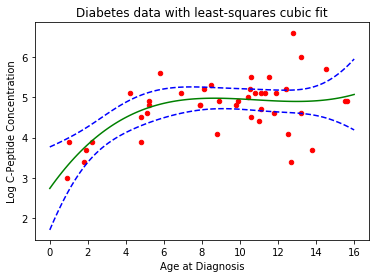

In [12]:
# %load ../solutions/exercise1-2.py
ax2 = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data with least-squares cubic fit")
ax2.set_xlabel("Age at Diagnosis")
ax2.set_ylabel("Log C-Peptide Concentration")

ax2.plot(predict_df.age, poly_predictions['mean'],color="green")
ax2.plot(predict_df.age, poly_predictions['mean_ci_lower'], color="blue",linestyle="dashed")
ax2.plot(predict_df.age, poly_predictions['mean_ci_upper'], color="blue",linestyle="dashed");

<div class="discussion"><b>Ed exercise</b></div>

This example was similar with the Ed exercise. [Open it in Ed](https://us.edstem.org/courses/172/lessons/656/slides/2916) and let's go though it. 

### 2 - Piecewise Polynomials a.k.a. Splines

Splines are a type of piecewise polynomial interpolant. A spline of degree k is a piecewise polynomial that is continuously differentiable k − 1 times. 

Splines are the basis of CAD software and vector graphics including a lot of the fonts used in your computer.  The name “spline” comes from a tool used by ship designers to draw smooth curves. Here is the letter $epsilon$ written with splines:

![](../images/epsilon.png)

*font idea inspired by David Knezevic (AM205)*

If the degree is 1 then we have a Linear Spline. If it is 3 then we have a Cubic spline. It turns out that cubic splines because they have a continous 2nd derivative at the knots are very smoothly looking to the eye. We do not need higher order than that. The Cubic Splines are usually **Natural Cubic Splines which means they have the added constrain of the end points' second derivative = 0.**

We will use the CubicSpline and the B-Spline as well as the Linear Spline.

#### scipy.interpolate

See all the different splines that scipy.interpolate has to offer: https://docs.scipy.org/doc/scipy/reference/interpolate.html

Let's use the simplest form which is interpolate on a set of points and then find the points between them.

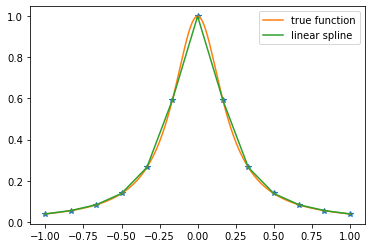

In [8]:
from scipy.interpolate import splrep, splev
from scipy.interpolate import BSpline, CubicSpline
from scipy.interpolate import interp1d

# define the range of the function
a = -1
b = 1

# define the number of knots 
num_knots = 13
x = np.linspace(a,b,num_knots)

# define the function we want to approximate
y = 1/(1+25*(x**2))

# make a linear spline
linspline = interp1d(x, y)

# sample at these points to plot
xx = np.linspace(a,b,1000)
yy = 1/(1+25*(xx**2))
plt.plot(x,y,'*')
plt.plot(xx, yy, label='true function')
plt.plot(xx, linspline(xx), label='linear spline');
plt.legend();

<div class="exercise"><b>Exercise 2</b></div>

The Linear interpolation does not look very good. Fit a Cubic Spline and plot along the Linear to compare.

In [ ]:
# your answer here


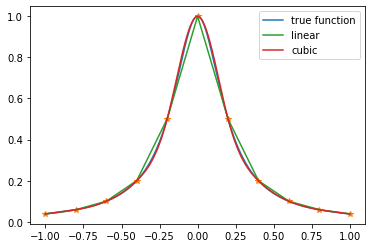

In [9]:
# %load ../solutions/exercise2.py
# define the range of the function
a = -1
b = 1

# define the knots 
num_knots = 11
x = np.linspace(a,b,num_knots)

# define the function we want to approximate
y = 1/(1+25*(x**2))

# make the Cubic spline
cubspline = CubicSpline(x, y)

# OR make a linear spline
linspline = interp1d(x, y)

# plot
xx = np.linspace(a,b,1000)
yy = 1/(1+25*(xx**2))
plt.plot(xx, yy, label='true function')
plt.plot(x,y,'*')
plt.plot(xx, linspline(xx), label='linear');
plt.plot(xx, cubspline(xx), label='cubic');
plt.legend();


<div class="discussion"><b>Discussion</b></div>

- Change the number of knots to 100 and see what happens. What would happen if we run a polynomial model of degree equal to the number of knots (a global one as in polynomial regression, not a spline)?
- What makes a spline 'Natural'?

#### B-Splines

A B-splines (Basis Splines) is defined by a set of **control points** and a set of **basis functions** that intepolate (fit) the function between these points. By choosing to have no smoothing factor we forces the final B-spline to pass though all the points. If, on the other hand, we set a smothing factor, our function is more of an approximation with the control points as "guidance". The latter produced a smoother curve which is prefferable for drawing software. For more on Splines see:  https://en.wikipedia.org/wiki/B-spline)

![](../images/B-spline.png)

We will use [`scipy.splrep`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html#scipy.interpolate.splrep) to calulate the coefficients for the B-Spline and draw it. 

#### B-Spline with no smooting

[ 0.          0.          0.          0.          2.22222222  3.33333333
  4.44444444  5.55555556  6.66666667  7.77777778 10.         10.
 10.         10.        ] [-4.94881722e-18  8.96543619e-01  1.39407154e+00 -2.36640266e-01
 -1.18324030e+00 -8.16301228e-01  4.57836125e-01  1.48720677e+00
  1.64338775e-01 -5.44021111e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00] 3


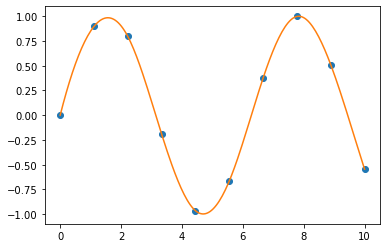

In [21]:
from scipy.interpolate import splev, splrep # Find the B-spline representation of 1-D curve.
x = np.linspace(0, 10, 10)
y = np.sin(x)

t,c,k = splrep(x, y) # (tck) is a tuple containing the vector of knots, coefficients, degree of the spline
print(t,c,k)
# define the points to plot on (x2)
x2 = np.linspace(0, 10, 200)
y2 = BSpline(t, c, k)
plt.plot(x, y, 'o', x2, y2(x2))
plt.show()

#### B-Spline with smooting factor s

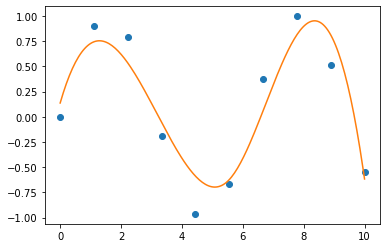

In [11]:
from scipy.interpolate import splev, splrep
x = np.linspace(0, 10, 10)
y = np.sin(x)

s = 0.5 # add smooting factor
task = 0 # task needs to be set to 0, which represents:
# we are specifying a smoothing factor and thus only want
# splrep() to find the optimal t and c

t,c,k = splrep(x, y, task=task, s=s)

# define the points to plot on (x2)
x2 = np.linspace(0, 10, 200)
y2 = BSpline(t, c, k)
plt.plot(x, y, 'o', x2, y2(x2))
plt.show()

#### B-Spline with given knots

In [12]:
x = np.linspace(0, 10, 100)
y = np.sin(x)
knots = np.quantile(x, [0.25, 0.5, 0.75])
print(knots)

[2.5 5.  7.5]


In [13]:
# calculate the B-Spline
t,c,k = splrep(x, y, t=knots)

In [14]:
curve = BSpline(t,c,k)
curve

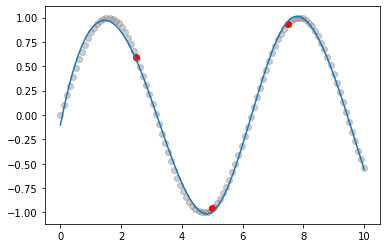

In [15]:
plt.scatter(x=x,y=y,c='grey', alpha=0.4)
yknots = np.sin(knots)
plt.scatter(knots, yknots, c='r')
plt.plot(x,curve(x))
plt.show()

<div class="discussion"><b>Ed exercise</b></div>

This example was similar with the Ed exercise. [Open it in Ed](https://us.edstem.org/courses/172/lessons/656/slides/2917) and let's go though it. 

### 3 - GAMs

https://readthedocs.org/projects/pygam/downloads/pdf/latest/

#### A - Classification in `pyGAM`

Let's get our (multivariate!) data, the `kyphosis` dataset, and the `LogisticGAM` model from `pyGAM` to do binary classification.

- kyphosis - wherther a particular deformation was present post-operation
- age - patient's age in months
- number - the number of vertebrae involved in the operation
- start - the number of the topmost vertebrae operated on

In [16]:
kyphosis = pd.read_csv("../data/kyphosis.csv")

display(kyphosis.head())
display(kyphosis.describe(include='all'))
display(kyphosis.dtypes)

,Kyphosis,Age,Number,Start
0,absent,71,3,5
1,absent,158,3,14
2,present,128,4,5
3,absent,2,5,1
4,absent,1,4,15


,Kyphosis,Age,Number,Start
count,81,81.000000,81.000000,81.000000
unique,2,NaN,NaN,NaN
top,absent,NaN,NaN,NaN
freq,64,NaN,NaN,NaN
mean,NaN,83.654321,4.049383,11.493827
std,NaN,58.104251,1.619423,4.883962
min,NaN,1.000000,2.000000,1.000000
25%,NaN,26.000000,3.000000,9.000000
50%,NaN,87.000000,4.000000,13.000000
75%,NaN,130.000000,5.000000,16.000000


Kyphosis    object
Age          int64
Number       int64
Start        int64
dtype: object

In [17]:
# convert the outcome in a binary form, 1 or 0
kyphosis = pd.read_csv("../data/kyphosis.csv")
kyphosis["outcome"] = 1*(kyphosis["Kyphosis"] == "present")
kyphosis.describe()

,Age,Number,Start,outcome
count,81.000000,81.000000,81.000000,81.000000
mean,83.654321,4.049383,11.493827,0.209877
std,58.104251,1.619423,4.883962,0.409758
min,1.000000,2.000000,1.000000,0.000000
25%,26.000000,3.000000,9.000000,0.000000
50%,87.000000,4.000000,13.000000,0.000000
75%,130.000000,5.000000,16.000000,0.000000
max,206.000000,10.000000,18.000000,1.000000


In [18]:
from pygam import LogisticGAM, s, f, l

X = kyphosis[["Age","Number","Start"]]
y = kyphosis["outcome"]
kyph_gam = LogisticGAM().fit(X,y)

#### Outcome dependence on features

To help us see how the outcome depends on each feature, `pyGAM` has the `partial_dependence()` function.
```
 pdep, confi = kyph_gam.partial_dependence(term=i, X=XX, width=0.95)
```
For more on this see the : https://pygam.readthedocs.io/en/latest/api/logisticgam.html


In [27]:
res = kyph_gam.deviance_residuals(X,y)
for i, term in enumerate(kyph_gam.terms):
    print(i,term)
print(kyph_gam.terms)

0 spline_term
1 spline_term
2 spline_term
3 intercept_term
s(0) + s(1) + s(2) + intercept


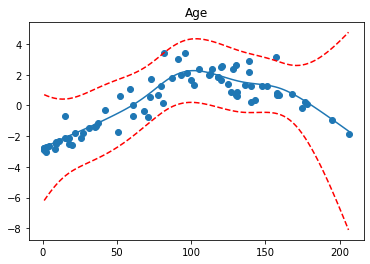

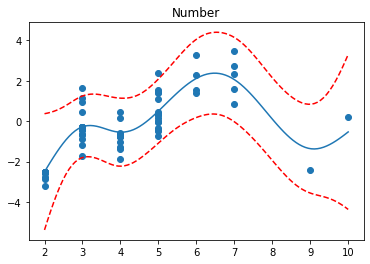

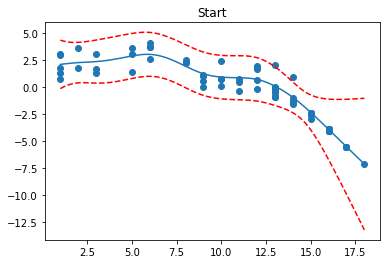

In [24]:
res = kyph_gam.deviance_residuals(X,y)
for i, term in enumerate(kyph_gam.terms):
    if term.isintercept:
        continue

    XX = kyph_gam.generate_X_grid(term=i)
    pdep, confi = kyph_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = kyph_gam.partial_dependence(term=i, X=X, width=0.95)
    plt.figure()
    plt.scatter(X.iloc[:,term.feature], pdep2 + res)
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X.columns.values[term.feature])
    plt.show()

Notice that we did not specify the basis functions in the .fit(). Cool. `pyGAM` figures them out for us by using $s()$ (splines) for numerical variables and $f()$ for categorical features. If this is not what we want we can manually specify the basis functions, as follows: 

In [25]:
kyph_gam = LogisticGAM(s(0)+s(1)+s(2)).fit(X,y)

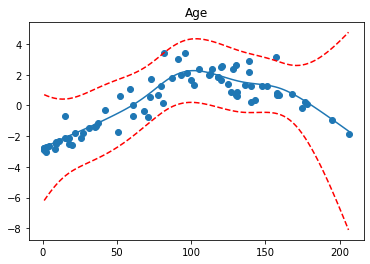

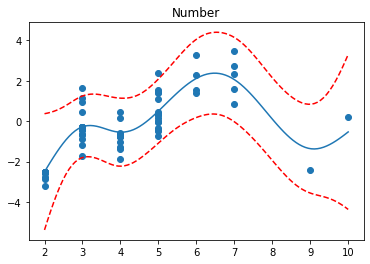

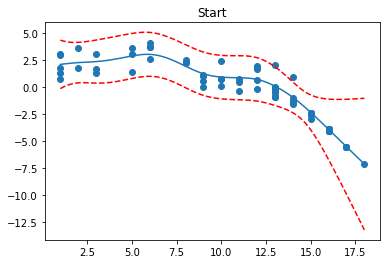

In [26]:
res = kyph_gam.deviance_residuals(X,y)
for i, term in enumerate(kyph_gam.terms):
    if term.isintercept:
        continue

    XX = kyph_gam.generate_X_grid(term=i)
    pdep, confi = kyph_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = kyph_gam.partial_dependence(term=i, X=X, width=0.95)
    plt.figure()
    plt.scatter(X.iloc[:,term.feature], pdep2 + res)
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X.columns.values[term.feature])
    plt.show()

#### B - Regression in `pyGAM`

For regression problems, we can use a `linearGAM` model. For this part we will use the `wages` dataset.

https://pygam.readthedocs.io/en/latest/api/lineargam.html

#### The `wages` dataset

Let's inspect another dataset that is included in `pyGAM` that notes the wages of people based on their age, year of employment and education.

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 432x288 with 0 Axes>

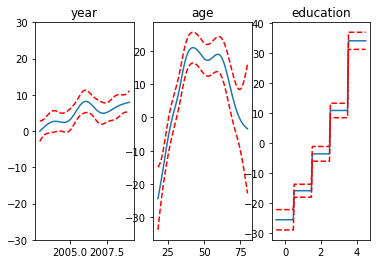

In [28]:
# from the pyGAM documentation
from pygam import LinearGAM, s, f
from pygam.datasets import wage

X, y = wage(return_X_y=True)

## model
gam = LinearGAM(s(0) + s(1) + f(2))
gam.gridsearch(X, y)


## plotting
plt.figure();
fig, axs = plt.subplots(1,3);

titles = ['year', 'age', 'education']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

<div class="discussion"><b>Discussion</b></div>

What are your observations from the plots above?

### 4 - Smoothing Splines using pyGAM

For clarity: this is the fancy spline model that minimizes $MSE - \lambda\cdot\text{wiggle penalty}$ $=$ $\sum_{i=1}^N \left(y_i - f(x_i)\right)^2 - \lambda \int \left(f''(x)\right)^2$, across all possible functions $f$. The winner will always be a continuous, cubic polynomial with a knot at each data point.

Let's see how this smoothing works in `pyGAM`. We start by creating some arbitrary data and fitting them with a GAM.

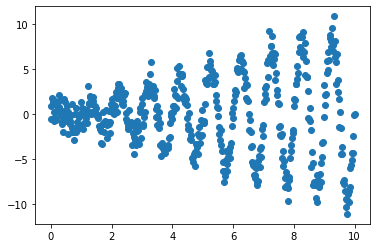

In [30]:
X = np.linspace(0,10,500)
y = np.sin(X*2*np.pi)*X + np.random.randn(len(X))

plt.scatter(X,y);

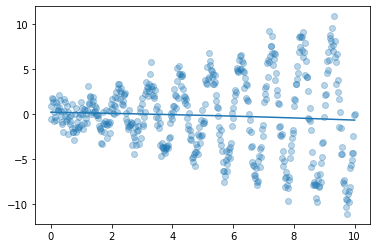

In [31]:
# let's try a large lambda first and lots of splines
gam = LinearGAM(lam=1e6, n_splines=50). fit(X,y)
XX = gam.generate_X_grid(term=0)
plt.scatter(X,y,alpha=0.3);
plt.plot(XX, gam.predict(XX));

We see that the large $\lambda$ forces a straight line, no flexibility. Let's see now what happens if we make it smaller.

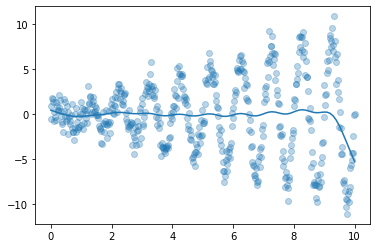

In [32]:
# let's try a smaller lambda 
gam = LinearGAM(lam=1e2, n_splines=50). fit(X,y)
XX = gam.generate_X_grid(term=0)
plt.scatter(X,y,alpha=0.3);
plt.plot(XX, gam.predict(XX));

There is some curvature there but still not a good fit. Let's try no penalty. That should have the line fit exactly.

In [ ]:
# no penalty, let's try a 0 lambda 
gam = LinearGAM(lam=0, n_splines=50). fit(X,y)
XX = gam.generate_X_grid(term=0)
plt.scatter(X,y,alpha=0.3)
plt.plot(XX, gam.predict(XX))

Yes, that is good. Now let's see what happens if we lessen the number of splines. The fit should not be as good.

In [ ]:
# no penalty, let's try a 0 lambda 
gam = LinearGAM(lam=0, n_splines=10). fit(X,y)
XX = gam.generate_X_grid(term=0)
plt.scatter(X,y,alpha=0.3);
plt.plot(XX, gam.predict(XX));

Indeed.